In [7]:
# In [1]
from google.colab import drive
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
import os

# 1. MOUNT GOOGLE DRIVE (UPDATED with force_remount=True)
drive.mount('/content/drive', force_remount=True)
# IMPORTANT: This path must match the one used in your data preparation files!
DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/L_GTA_model_DATA/'

# =======================================================
# PROJECT CONFIGURATION (CRITICAL)
# =======================================================
# NOTE: Set to the dataset you are running the Base Model on.
DATASET_TO_TEST = "sf_crime" # <<< CHANGED TO TOURISM


# 2. Adjust Hyperparameters based on complexity:
if DATASET_TO_TEST == "m5_forecasting":
    LATENT_DIM = 16
    EPOCHS = 30
else: # tourism and sf_crime (univariate)
    LATENT_DIM = 4
    EPOCHS = 20

BATCH_SIZE = 32
LEARNING_RATE = 0.001
# =======================================================
# =======================================================

print(f"Testing Model on: {DATASET_TO_TEST.upper()}")
print(f"Hyperparameters: LATENT_DIM={LATENT_DIM}, EPOCHS={EPOCHS}, BATCH_SIZE={BATCH_SIZE}")

Mounted at /content/drive
Testing Model on: SF_CRIME
Hyperparameters: LATENT_DIM=4, EPOCHS=20, BATCH_SIZE=32


In [8]:
# In [2]
print("\n2. Loading processed data...")

try:
    # Use the permanent DRIVE_PATH to load the files
    X_train = np.load(f'{DRIVE_PATH}{DATASET_TO_TEST}_X_train.npy')
    X_test = np.load(f'{DRIVE_PATH}{DATASET_TO_TEST}_X_test.npy')
except FileNotFoundError:
    print(f"❌ ERROR: Cannot find '{DATASET_TO_TEST}_X_train.npy'. Check the path: {DRIVE_PATH}")
    print("ACTION REQUIRED: Ensure all data prep files have been run to save data to this Drive location.")
    exit()

# Derive necessary shapes from the loaded data
INPUT_SHAPE = X_train.shape[1:]
TIME_STEPS = INPUT_SHAPE[0]
N_FEATURES = INPUT_SHAPE[1]

print(f"Loaded Training Data Shape: {X_train.shape}")
print(f"Model Input Shape (Time_steps, Features): {INPUT_SHAPE}")


2. Loading processed data...
Loaded Training Data Shape: (1760, 50, 1)
Model Input Shape (Time_steps, Features): (50, 1)


In [9]:
# In [3]
# --- CORE MODEL COMPONENTS ---

# A. Sampling Layer for VAE (Re-parameterization trick)
class Sampling(layers.Layer):
    """Encodes the output of the encoder into a latent space z using Z_mean and Z_log_var."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


# B. Decoder (SHARED - Bi-LSTM)
def build_decoder(latent_dim, output_shape):
    """Standard Bi-LSTM decoder for time series reconstruction."""
    latent_inputs = layers.Input(shape=(latent_dim,))

    x = layers.RepeatVector(output_shape[0])(latent_inputs)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)

    outputs = layers.TimeDistributed(layers.Dense(output_shape[1], activation='sigmoid'))(x)

    return keras.Model(latent_inputs, outputs, name="BiLSTM_Decoder")

# C. BASE ENCODER (L-GTA - Transformer/VMHA Equivalent)
def build_base_encoder(input_shape, latent_dim):
    """Implements the high-complexity encoder with Bi-LSTM and Attention."""
    inputs = layers.Input(shape=input_shape)

    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(inputs)

    # Simplified Transformer Block (Attention for long-range dependencies)
    attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + attention_output)

    x = layers.GlobalAveragePooling1D()(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])

    return keras.Model(inputs, [z_mean, z_log_var, z], name="Base_Transformer_Encoder")

print("Model components defined.")

Model components defined.


In [10]:
# In [4]
# D. L-GTA VAE Implementation (Handles VAE Loss)
class L_GTA_CVAE(keras.Model):
    """The main CVAE class handling the combined Reconstruction and KL Divergence loss."""
    def __init__(self, encoder, decoder, **kwargs):
        super(L_GTA_CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # --- VAE Loss Calculation ---
            # Reconstruction Loss (Mean Squared Error - MSE)
            # We use axis=1 because for univariate data (N_FEATURES=1),
            # tf.keras.losses.mse output shape is often (Batch, Time).
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.mse(data, reconstruction), axis=1)
            )

            # KL Divergence Loss
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # Total Loss: RECONSTRUCTION_LOSS + KL_LOSS
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

print("L_GTA_CVAE class defined (MSE axis fixed).")

L_GTA_CVAE class defined (MSE axis fixed).


In [11]:
# In [5]
print("\n3. Training Base Model and generating report...")

# --- TRAIN BASE MODEL (L-GTA) ---
print("\n--- BASE MODEL: Training Transformer/Bi-LSTM L-GTA ---")
base_encoder = build_base_encoder(INPUT_SHAPE, LATENT_DIM)
base_decoder = build_decoder(LATENT_DIM, INPUT_SHAPE)
base_model = L_GTA_CVAE(base_encoder, base_decoder)
base_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

start_time_base = time.time()
hist_base = base_model.fit(X_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
end_time_base = time.time()
avg_time_base = (end_time_base - start_time_base) / EPOCHS

# --- QUANTITATIVE ANALYSIS ---
base_params = base_encoder.count_params() + base_decoder.count_params()

# Print available keys to confirm 'total_loss' exists
print(f"\nAvailable History Keys: {hist_base.history.keys()}")

try:
    final_base_loss = hist_base.history['total_loss'][-1]
except KeyError:
    print("❌ ERROR: 'total_loss' key not found. Check L_GTA_CVAE metrics definition.")
    final_base_loss = 0.0

# --- REPORT GENERATION ---
print(f"\n===================================================================")
print(f"| BASE MODEL PERFORMANCE REPORT - Dataset: {DATASET_TO_TEST.upper():<16} |")
print(f"===================================================================")
print(f"| Metric                      | Base Model (Trans/Bi-LSTM) |")
print(f"|-----------------------------|----------------------------|")
print(f"| Total Parameters            | {base_params:<26,} |")
print(f"| Avg Training Time/Epoch (s) | {avg_time_base:<26.4f} |")
print(f"| Final Total Loss            | {final_base_loss:<26.4f} |")
print(f"===================================================================")


3. Training Base Model and generating report...

--- BASE MODEL: Training Transformer/Bi-LSTM L-GTA ---
Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 198ms/step - kl_loss: 0.6985 - reconstruction_loss: 0.5270 - total_loss: 1.2255
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - kl_loss: 0.0017 - reconstruction_loss: 0.3044 - total_loss: 0.3061
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - kl_loss: 5.6170e-04 - reconstruction_loss: 0.2943 - total_loss: 0.2948
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step - kl_loss: 6.2144e-04 - reconstruction_loss: 0.2920 - total_loss: 0.2926
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - kl_loss: 6.3316e-04 - reconstruction_loss: 0.2904 - total_loss: 0.2910
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - kl_loss: 6.2317e-04 - reconstruction_loss: 0.2888 - total_loss: 0.2894
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 214ms/step - kl_loss: 0.0015 - reconstruction_loss: 0.2942 - total_loss: 0.2957
Epoch 8/20
55/55 ━━━━━━━━


4. Generating Visual Results for Paper...


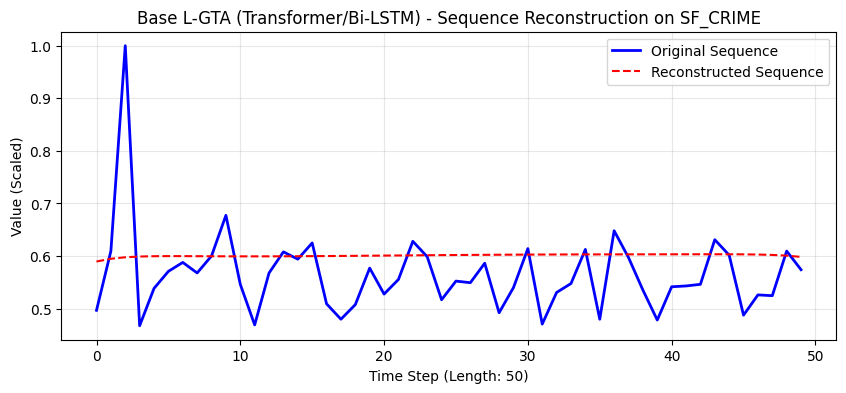


Done! Weights saved as base_L_GTA_sf_crime.weights.h5. Review the report and plots.


In [12]:
# In [6]
# --- VISUAL ANALYSIS & DELIVERABLES ---

def plot_comparison(model, data, title, sample_index=0):
    """Plots the reconstruction quality of a single sequence."""

    if N_FEATURES > 1:
        print(f"Note: Plotting only the first feature (index 0) of the {N_FEATURES}-feature sequence.")

    # 1. Get latent outputs (z_mean, z_log_var, z)
    latent_outputs = model.encoder.predict(data, verbose=0)
    # 2. Grab the deterministic mean vector (z_mean)
    z_mean = latent_outputs[0]

    # 3. Decode z_mean to get the reconstruction
    reconstructions = model.decoder.predict(z_mean, verbose=0)

    # Select the specified sequence and the first feature
    original_sequence = data[sample_index, :, 0]
    reconstructed_sequence = reconstructions[sample_index, :, 0]

    plt.figure(figsize=(10, 4))
    plt.plot(original_sequence, label="Original Sequence", linewidth=2, color='blue')
    plt.plot(reconstructed_sequence, label="Reconstructed Sequence", linestyle="--", color='red')
    plt.title(f"{title} - Sequence Reconstruction on {DATASET_TO_TEST.upper()}")
    plt.xlabel(f"Time Step (Length: {TIME_STEPS})")
    plt.ylabel("Value (Scaled)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

print("\n4. Generating Visual Results for Paper...")
# Use a sample from the test set for visual evaluation
plot_comparison(base_model, X_test, "Base L-GTA (Transformer/Bi-LSTM)")

# --- SAVE WEIGHTS ---
# Force a forward pass to build the model structure
base_model.build(input_shape=(None,) + INPUT_SHAPE)
base_model(X_test[:1])

# Save weights to the current Colab runtime directory
base_model.save_weights(f"base_L_GTA_{DATASET_TO_TEST}.weights.h5")
print(f"\nDone! Weights saved as base_L_GTA_{DATASET_TO_TEST}.weights.h5. Review the report and plots.")